In [1]:
from sympy import *
import numpy as np
from itertools import combinations
import pandas as pd
import numpy as np
import sys

sys.path.append('./')

print(sys.path)

import pyximport; pyximport.install(inplace=True)
from direct_lingam.ReLVLiNGAM import *
from direct_lingam.simulate_data import *
from direct_lingam.DAG import plot_dag
from direct_lingam import constraints_to_test


['/home/ykivva/ykivva/research/iv_dependant/generilized_did', '/home/ykivva/anaconda3/envs/experiments/lib/python311.zip', '/home/ykivva/anaconda3/envs/experiments/lib/python3.11', '/home/ykivva/anaconda3/envs/experiments/lib/python3.11/lib-dynload', '', '/home/ykivva/anaconda3/envs/experiments/lib/python3.11/site-packages', './']


In [2]:
import numpy as np
from direct_lingam.DAG import adjacency_to_path_matrix

def get_Lambda(edges, p):
    return np.array([[1 if (v, w) in edges else 0 for w in range(p)] for v in range(p)])

def get_Gamma(edges, p, q):
    return np.array([[1 if (v, w) in edges else 0 for w in range(p, q)] for v in range(p)])

all_settings = {
    "a": {'Lambda': np.tril(np.ones((2, 2)), k=-1), 'Gamma': np.ones((2, 1)), 'highest_l': 1},
    "b": {'Lambda': get_Lambda([(1,0), (2, 1)], 3), 'Gamma': np.array([[0], [1], [1]]), 'highest_l': 1},
    "c": {'Lambda': get_Lambda([(1,0), (2,1)], 3), 'Gamma': np.array([[1, 0], [1, 1], [0, 1]]), 'highest_l': 1},
    "d": {'Lambda': np.tril(np.ones((3, 3)), k=-1), 'Gamma': np.ones((3, 1)), 'highest_l': 1},
    "e": {'Lambda': np.tril(np.ones((3, 3)), k=-1), 'Gamma':np.ones((3, 2)), 'highest_l': 2},
    'f': {'Lambda': get_Lambda([(1,0), (2,0), (3,1), (4,1)], 5),
          'Gamma': np.array([[1, 0], [1, 1], [0, 0], [1, 0], [0, 1]]), 'highest_l': 1}
}

def simulate_data(n, noise_distribution, Lambda, Gamma, par = 2, permute_order=True):
    """
    Simulate data according to a linear non-Gaussian acyclic model with latent confounfing.

    Parameters:
    - n (int): Sample size.
    - noise_distribution (str): Distribution for exogeneous sources epsilon, L. Options are "gamma", "beta", or "lognormal".
    - Lambda (ndarray): Coefficient matrix for the direct effects among observed variables.
    - Gamma (ndarray): Coefficient matrix for the direct effects from latent on observed variables.
    - permute_order (bool, optional): Whether to randonmly permute the order of variables. Otherwise X is in topological order. Defaults to True.

    Returns:
    - X (ndarray): Generated data with shape (n, p), where p is the number of variables.
    - B (ndarray): Path matrix with shape (q, p), where q is the total number of variables including noise variables.
    """
    adjacency = np.hstack((Lambda, Gamma))
    p, q = adjacency.shape

    adjacency = np.where(adjacency == 1, np.random.choice([-1, 1], adjacency.shape) * np.random.uniform(0.5, 0.9, adjacency.shape), 0)
    oldest_children = np.argmax(adjacency[:, p:] != 0, axis=0)
    adjacency[oldest_children, range(p, q)] = 1

    if permute_order:
        permutation = np.random.permutation(p)
        adjacency = adjacency[permutation]
        adjacency[:, :p] = adjacency[:, permutation]

    B = adjacency_to_path_matrix(adjacency)
    eta = sample_eta(n, q, noise_distribution, par = par)
    # Fortran array as required by moment estimation function
    X = np.asfortranarray(eta @ np.transpose(B))
    return X, B

def sample_eta(n, q, noise_distribution, par = 2):
    """
    Generate samples for eta from a specified distribution.

    Parameters:
    - n (int): Sample size.
    - q (int): Number of exogeneous sources, i.e. l+p.
    - noise_distribution (str): Distribution. Options are "gamma", "beta", or "lognormal".

    Returns:
    - ndarray: Generated samples for eta with shape (n, q).
    """
    if noise_distribution == "gamma":
        shapes = np.random.uniform(0.1, 1, q)
        scales = np.random.uniform(0.1, 0.5, q)
        eta = np.array([np.random.gamma(shape, scale, n) - shape * scale for shape, scale in zip(shapes, scales)])
    elif noise_distribution == "beta":
        # alphas = np.random.uniform(1.5, 2, q)
        alphas = [par]*q
        # betas = np.random.uniform(2, 10, q)
        betas = [par]*q
        eta = np.array([np.random.beta(alpha, beta, n) - alpha / (alpha + beta) for alpha, beta in zip(alphas, betas)])
    elif noise_distribution == "lognormal":
        mus = np.random.uniform(-2, -0.5, q)
        sigmas = np.random.uniform(0.1, 0.4, q)
        eta = np.array([np.random.lognormal(mu, sigma, n) - np.exp(mu + sigma ** 2 / 2) for mu, sigma in zip(mus, sigmas)])

    return np.transpose(eta)

In [3]:
print(constraints_to_test.get_cumulant_formula([0,0,1,1]))


-m_00*m_11 + m_0011 - 2*m_01**2


Lambda is 
 [[0 0 0]
 [1 0 0]
 [0 1 0]]


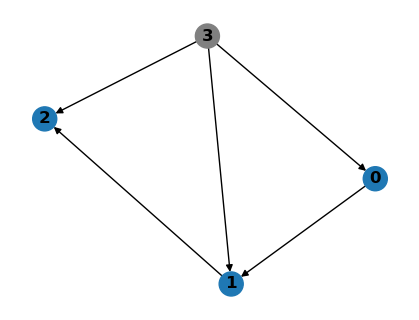

In [4]:
Lambda = get_Lambda([(1,0), (2, 1)], 3)
print(f"Lambda is \n {Lambda}")
Gamma = np.array([[1], [1], [1]])
highest_l = 1
plot_dag(np.hstack((Lambda, Gamma))) # Latent nodes are grey

In [7]:
from direct_lingam.constraints_to_test import get_constraints_for_l_latents
class DiDLiNGAM(ReLVLiNGAM):
    def __init__(self,
                 *args,
                 **kwargs):
        """
        Initialize the DiDLiNGAM model.

        Parameters:
        *args: positional arguments
        **kwargs: keyword arguments
        """
        super().__init__(*args, **kwargs)
        self.cumulants = self._estimate_cumulants(self.X)
        self.roots_10, self.cum_10 = self.__get__roots(i=1, j=0)
        self.roots_20, self.cum_20 = self.__get__roots(i=2, j=0)



    def estimate_effect(self, method="cumulant", true_B = None):
        """
        Estimate the causal effect using the specified method.

        Parameters:
        method (str): The method to use for effect estimation. Can be "ratio" or "cumulant".

        Raises:
        ValueError: If the specified method is not supported.
        """
        if method == "ratio":
            matching_1 = [[self.roots_10[0], self.roots_20[0]], [self.roots_10[1], self.roots_20[1]]]
            matching_2 = [[self.roots_10[0], self.roots_20[1]], [self.roots_10[1], self.roots_20[0]]]
            matchings = [matching_1, matching_2]
            self.matchings = matchings
            self.causal_effect = self.__estimate__effect_ratio()
        elif method == "cumulant":
            marginal_omegas_10 = self.__marginal__cumulants(j=0, i=1)
            marginal_omegas_20 = self.__marginal__cumulants(j=0, i=2)
            match = self.__match__marginals(marginal_omegas_10, marginal_omegas_20)
            roots_1 = [self.roots_10[match[0][0]], self.roots_20[match[0][1]]]
            roots_2 = [self.roots_10[match[1][0]], self.roots_20[match[1][1]]]
            self.roots = [roots_1, roots_2]
            self.causal_effect = self.__estimate__effect_cumulant(roots_1, roots_2)
        elif method == "cumulant_with_true_matrix":
            self.causal_effect = self.__estimate__effect_cumulant(true_B[1:, 0], true_B[1:, 3])
        elif method == "ratio_after_matching":
            marginal_omegas_10 = self.__marginal__cumulants(j=0, i=1)
            marginal_omegas_20 = self.__marginal__cumulants(j=0, i=2)
            match = self.__match__marginals(marginal_omegas_10, marginal_omegas_20)
            self.causal_effect = self.__estimate__effect_ratio_after_matching(match)
        else:
            raise ValueError(f"Method {method} is not supported.")

    def __get__roots(self, i=1, j=0):
        """
        Get the roots of the polynomial equations for the specified nodes.

        Parameters:
        i (int): The index of the first node.
        j (int): The index of the second node.

        Returns:
        numpy.ndarray: The roots of the polynomial equations.
        """
        equations_bij = get_constraints_for_l_latents(1)["equations_bij"]
        b_ij = symbols('b_ij')
        eq = equations_bij[2]
        # coeff_bij = eq.coeff_monomial(b_ij)
        #  eq_modified = eq - coeff_bij * b_ij
        # eq = eq_modified
        # display(eq)
        # eq = sum(equations_bij)

        # for eq in equations_bij:
        specify_nodes = {
            sym: symbols(
                sym.name[:2] + "".join(sorted(sym.name[2:].replace("j", str(j)).replace("i", str(i))))
            )
            for sym in reduce(set.union, [eq.free_symbols for eq in equations_bij])
            if str(sym) != "b_ij"
        }
        symbols_to_cumulants = self._form_symbol_to_cumulant_dict(self.cumulants, [i, j], scale_partly=False)



        estimated_coeffs = [float(coeff.subs(specify_nodes).subs(symbols_to_cumulants)) for coeff in eq.all_coeffs()]
        if i == 1:
            print(np.polynomial.Polynomial(estimated_coeffs[::-1]))
        # print(specify_nodes)
        roots = np.polynomial.Polynomial(estimated_coeffs[::-1]).roots().astype(np.float64)

        return roots, symbols_to_cumulants

    def __marginal__cumulants(self, j=0, i=1):
        """
        Estimate the marginal cumulants for the specified nodes.

        Parameters:
        j (int): The index of the first node.
        i (int): The index of the second node.

        Returns:
        numpy.ndarray: The estimated marginal cumulants.
        """
        source, other_node = j, i
        l = self.highest_l  # The number of latent variables confounding 1 and 2
        highest_order = 4  # Order up to which to estimate cumulants
        marginal_omegas = np.full((self.highest_l + 1, self.highest_order - 1), np.nan)
        # For k < l+1, the marginal omega cannot be inferred.
        for k in range(l + 1, highest_order + 1):
            roots = self.roots_10 if i == 1 else self.roots_20
            B_tilde = [roots ** i for i in range(k)]
            symbols_to_cumulants = self._form_symbol_to_cumulant_dict(self.cumulants, [i, j], scale_partly=False)
            y = np.array(
                [
                    float(symbols_to_cumulants[symbols(f"c_{''.join(sorted((str(source),) * (k - i) + (str(other_node),) * i))}")])
                    for i in range(k)
                ]
            )
            try:
                marginal_omegas[:, k - 2] = np.linalg.lstsq(B_tilde, y, rcond=None)[0]
            except np.linalg.LinAlgError:
                raise MathError(f"Linear system for {k}th order omega for source {source} and test node {other_node} is singular.")

        return marginal_omegas

    def __match__marginals(self, marginal_omegas_10, marginal_omegas_20):
        """
        Match the marginal cumulants of the two nodes.

        Parameters:
        marginal_omegas_10 (numpy.ndarray): The marginal cumulants of node 1.
        marginal_omegas_20 (numpy.ndarray): The marginal cumulants of node 2.

        Returns:
        list: The matching indices for the marginal cumulants.
        """
        if marginal_omegas_10.shape[0] != marginal_omegas_20.shape[0]:
            raise ValueError("The number of rows of the marginal omegas must be the same.")
        if marginal_omegas_10.shape[1] != marginal_omegas_20.shape[1]:
            raise ValueError("The number of columns of the marginal omegas must be the same.")
        match_1, match_2 = [[0, 0], [1, 1]], [[0, 1], [1, 0]]
        dist_1 = np.sum(np.abs((marginal_omegas_10 - marginal_omegas_20)))
        dist_2 = np.sum(np.abs((marginal_omegas_10 - marginal_omegas_20[[1, 0]])))
        if dist_1 < dist_2:
            return match_1
        else:
            return match_2

    def __estimate__effect_cumulant(self, roots_1, roots_2):
        """
        Estimate the causal effect using the cumulant method.

        Parameters:
        match (list): The matching indices for the marginal cumulants.

        Returns:
        float: The estimated causal effect.
        """
        def ratio_formula(root, cov_matrix):
            return (cov_matrix[1, 2] - root * cov_matrix[0, 2]) / (cov_matrix[1, 1] - root * cov_matrix[0, 1])

        # Estimate the causal effect
        b_2 = ratio_formula(roots_1[0], self.cumulants.get(2))
        b_1 = ratio_formula(roots_2[0], self.cumulants.get(2))

        diff_1 = np.abs(roots_1[1] - b_1 * roots_1[0])
        diff_2 = np.abs(roots_2[1] - b_2 * roots_2[0])

        if np.argmin([diff_1, diff_2]) == 0:
            return b_1
        else:
            return b_2

    def __estimate__effect_ratio(self):
        """
        Estimate the causal effect using the ratio method.

        Returns:
        float: The estimated causal effect.
        """
        matchings = self.matchings
        ratios = []
        for matching in matchings:
            X_matching = []
            for pair in matching:
                X_pair = self.X.copy()
                X_pair[:, 1] -= self.X[:, 0] * pair[0]
                X_pair[:, 2] -= self.X[:, 0] * pair[1]
                X_matching.append(X_pair)

            var_1 = np.cov([X_matching[0][:, 1], X_matching[1][:, 1]])[0, 1]
            cov_1 = np.cov(X_matching[0][:, 1], X_matching[1][:, 2])[0, 1]
            cov_2 = np.cov(X_matching[1][:, 1], X_matching[0][:, 2])[0, 1]

            ratio = sorted([cov_1/var_1, cov_2/var_1], key = abs)
            ratios.append(ratio)

        diff_ratios = [np.abs(r[1] - r[0]) for r in ratios]
        # return np.mean(ratios[diff_ratios.index(min(diff_ratios))])
        return np.mean(ratios[np.argmin(diff_ratios)])




    def __estimate__effect_ratio_after_matching(self, match):
        """
        Estimate the causal effect using the latent factor method.

        Parameters:
        match (list): The matching indices for the marginal cumulants.

        Returns:
        float: The estimated causal effect.
        """

        roots_1 = [self.roots_10[match[0][0]], self.roots_20[match[0][1]]]
        roots_2 = [self.roots_10[match[1][0]], self.roots_20[match[1][1]]]
        roots = [roots_1, roots_2]
        X_regs = []
        for root in roots:
            X_pair = self.X.copy()
            X_pair[:, 1] -= self.X[:, 0] * root[0]
            X_pair[:, 2] -= self.X[:, 0] * root[1]
            X_regs.append(X_pair)

        var_1 = np.cov([X_regs[0][:, 1], X_regs[1][:, 1]])[0, 1]
        cov_1 = np.cov(X_regs[0][:, 1], X_regs[1][:, 2])[0, 1]
        cov_2 = np.cov(X_regs[1][:, 1], X_regs[0][:, 2])[0, 1]


        return  np.mean([cov_1/var_1, cov_2/var_1])

In [8]:
def get_ratio_(Z, D, deg=2):
    """
    Computes ratio between alpha_d/alpha_z

    Parameters:
        - Z (np.array): proxy variable observations
        - D (np.array): treatment observations
        - deg (int): moment of non-guassianity (equal to the (n-1) from the original paper)
    """
    var_u = np.mean(Z*D)
    sign = np.sign(var_u)

    diff_normal_D = np.mean(D**(deg)*Z) - deg*var_u*np.mean(D**(deg-1))
    diff_normal_Z = np.mean(Z**(deg)*D) - deg*var_u*np.mean(Z**(deg-1))

    alpha_sq = ((diff_normal_D) / (diff_normal_Z))
    if alpha_sq < 0:
        alpha_sq = -(abs(alpha_sq)**(1/(deg-1)))
    else:
        alpha_sq = alpha_sq**(1/(deg-1))
    alpha_sq = abs(alpha_sq)*sign

    return alpha_sq


def cross_moment(Z, D, Y, deg=2):
    """
    Cross-Moment method implementation

    Parameters:
        - Z (np.array): proxy variable observations
        - D (np.array): treatment observations
        - Y (np.array): outcome observations
        - deg (int): moment of non-guassianity (equal to the (n-1) from the original paper)
    """
    denominator = 0
    while denominator==0:
        alpha_sq = get_ratio_(Z, D, deg)
        numerator = np.mean(D*Y) - alpha_sq*np.mean(Y*Z)
        denominator = np.mean(D*D) - alpha_sq*np.mean(D*Z)
        deg += 1
    return numerator / denominator

In [9]:
import concurrent.futures
from scipy.linalg import norm
from sympy import symbols, simplify
import warnings

warnings.filterwarnings("ignore")

def eval_matching(roots, true_B):
    return min([norm(roots[0]-true_B[1:,0], 1)/norm(true_B[1:,0], 1) + norm(roots[1]-true_B[1:,3], 1)/norm(true_B[1:,3], 1), norm(roots[1]-true_B[1:,0], 1)/norm(true_B[1:,0], 1) + norm(roots[0]-true_B[1:,3], 1)/norm(true_B[1:,3], 1)])/2
reps = 1
seeds_df = []


noise_distribution = 'beta'
samples_sizes = [3, 5, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
n_max = int(max(samples_sizes))

seed = 1
np.random.seed(seed)

par = 2
X, true_B = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, par = par, permute_order=False)
causal_effect_true = true_B[2, 1]

print(true_B)

# m4 = 0.00536 #beta with alpha=beta=2
# m4 = 0.005 #beta with alpha=beta=2

# m4 = 0.00535714 #beta with alpha=beta=2
# m2 = 0.05

m2 = 1/(4*(2*par + 1))
m4 = 1/(16*(2*par + 1)*(2*par + 3))

b03 = true_B[0, 3]
b13 = true_B[1, 3]
b10 = true_B[1, 0]

c00 = m2*(b03**2 + 1)
c3333 = m4-3*m2**2
c0000 = c3333*(b03**4 + 1)
c0001 = c3333*b10 + c3333*(b03**3)*b13
c0011 = c3333*(b10**2) + c3333*(b03*b13)**2
c0111 = c3333*(b10**3) + c3333*b03*(b13**3)

a = c0000*c0011 - c0001**2
b = c0001*c0011 - c0000*c0111
c = c0001*c0111 - c0011**2
d = b**2-4*a*c


true_cum = [c00, c0000, c0001, c0011, c0111]
print("TRUE cumulants", true_cum)

true_poly_coeff = [a, b, c]
print("TRUE poly coeff", true_poly_coeff)
true_sols = np.array([(-b + np.sqrt(d))/(2*a), (-b - np.sqrt(d))/(2*a)])

print("TRUE roots", true_sols)

for n in samples_sizes:
    print("------", "sample size:", int(n), "------")
    X_sample = X[:int(n), :]
    X_sample = np.asfortranarray(X_sample)
    X_sample = X_sample - np.mean(X_sample, axis=0)

    did_model = DiDLiNGAM(X_sample, highest_l = 1)
    did_model.estimate_effect("cumulant")
    cum_10 = did_model.cum_10

    est_cum = [cum_10[symbols('c_00')], cum_10[symbols('c_0000')], cum_10[symbols('c_0001')], cum_10[symbols('c_0011')], cum_10[symbols('c_0111')]]

    est_poly_coeff = [est_cum[1]*est_cum[3] - est_cum[2]**2, est_cum[2]*est_cum[3] - est_cum[1]*est_cum[4], est_cum[2]*est_cum[4] - est_cum[3]**2]

    a_est = est_poly_coeff[2]
    b_est = est_poly_coeff[1]
    c_est = est_poly_coeff[0]
    d_est = b_est**2-4*a_est*c_est

    est_sols = np.array([(-b_est + np.sqrt(d_est))/(2*a_est), (-b_est - np.sqrt(d_est))/(2*a_est)])

    est_cum = np.array(est_cum)
    true_cum = np.array(true_cum)
    est_poly_coeff = np.array(est_poly_coeff)
    true_poly_coeff = np.array(true_poly_coeff)

    roots = np.array([did_model.roots_10[1], did_model.roots_10[0]])

    print("\n")
    print("TRUE cumulants", true_cum)
    print("ESTIMATE cumulant", est_cum)
    print("ERROR cumulant", np.abs(((est_cum - true_cum))))
                                #    /(true_cum)))
    print("\n")

    print("TRUE poly coeff", true_poly_coeff)
    print("ESTIMATE poly coeff", est_poly_coeff)
    print("ERROR poly coeff", np.abs(((est_poly_coeff - true_poly_coeff))))
                                    #  /(true_poly_coeff)))
    print("\n")

    print("TRUE roots", true_sols)
    print("ESTIMATE roots", roots)
    print("ERROR roots", np.abs((roots - true_sols)))
                                # /true_sols))
    print("\n")

    print("ESTIMATE solution", est_sols)
    print("ERROR solution", np.abs((est_sols - true_sols)))
                                #    /true_sols))

[[ 1.          0.          0.          1.        ]
 [ 0.66767781  1.          0.          1.51892478]
 [-0.51290141 -0.768187    1.         -0.44334235]]
TRUE cumulants [0.1, -0.011428571428571432, -0.012494871920451513, -0.01573100651753949, -0.021725755631389163]
TRUE poly coeff [2.3661107320535098e-05, -5.173743845657516e-05, 2.3995967934365868e-05]
TRUE roots [1.51892478 0.66767781]
------ sample size: 3 ------
-1.15440523e-06 - (4.51452888e-07)·x + (1.33503496e-06)·x²


TRUE cumulants [ 0.1        -0.01142857 -0.01249487 -0.01573101 -0.02172576]
ESTIMATE cumulant [ 0.02854826 -0.0012225  -0.0002067  -0.001127   -0.00055984]
ERROR cumulant [0.07145174 0.01020607 0.01228817 0.01460401 0.02116592]


TRUE poly coeff [ 2.36611073e-05 -5.17374385e-05  2.39959679e-05]
ESTIMATE poly coeff [ 1.33503496e-06 -4.51452888e-07 -1.15440523e-06]
ERROR poly coeff [2.23260724e-05 5.12859856e-05 2.51503732e-05]


TRUE roots [1.51892478 0.66767781]
ESTIMATE roots [ 1.11421825 -0.77606015]
ERROR roots

In [10]:
from sympy import symbols, simplify


# Define the symbols
b03, gamma, b10, m2, m4 = symbols('b03 gamma b10 m2 m4')

# Define the formula for c0011
c0011_expr = -(b03**2 * m2 + m2)*(gamma**2 * m2 + b10**2 * m2 + m2) - 2*(gamma*b03*m2 + b10*m2)**2 + (gamma**2*b03**2*m4 + gamma**2*m2**2 + b03**2*b10**2*m2**2 + b10**2*m4 + b03**2*m2**2 + m2**2 + 4*gamma*b03*m2**2)

# Simplify the formula
c0011_simplified = simplify(c0011_expr)
print("Simplified c0011:", c0011_simplified)

Simplified c0011: -3*b03**2*gamma**2*m2**2 + b03**2*gamma**2*m4 - 4*b03*b10*gamma*m2**2 + 4*b03*gamma*m2**2 - 3*b10**2*m2**2 + b10**2*m4
